# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Real Potential Gross Domestic Product

### 1. Importing your libraries and data

Before you start this analysis, you'll need a new library you haven't installed before—Quandl. Install Quandl using conda:

`conda install quandl`

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

C:\Users\abdul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\abdul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
# Configure API key 

quandl.ApiConfig.api_key = 'sYxTpadHpFfeKWncUzMm'

In [4]:
# Importing the Real Potential Gross Domestic Product: "Real Potential Gross Domestic Product" variable.

data = quandl.get('FRED/GDPPOT')

In [5]:
data.head(5)

,Value
Date,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


In [6]:
data.tail(5)

,Value
Date,
2030-10-01,23423.37
2031-01-01,23522.55
2031-04-01,23622.05
2031-07-01,23721.65
2031-10-01,23821.31


In [7]:
data.shape

(332, 1)

In [10]:
data.dtypes

Value    float64
dtype: object

In [11]:
type(data)

pandas.core.frame.DataFrame

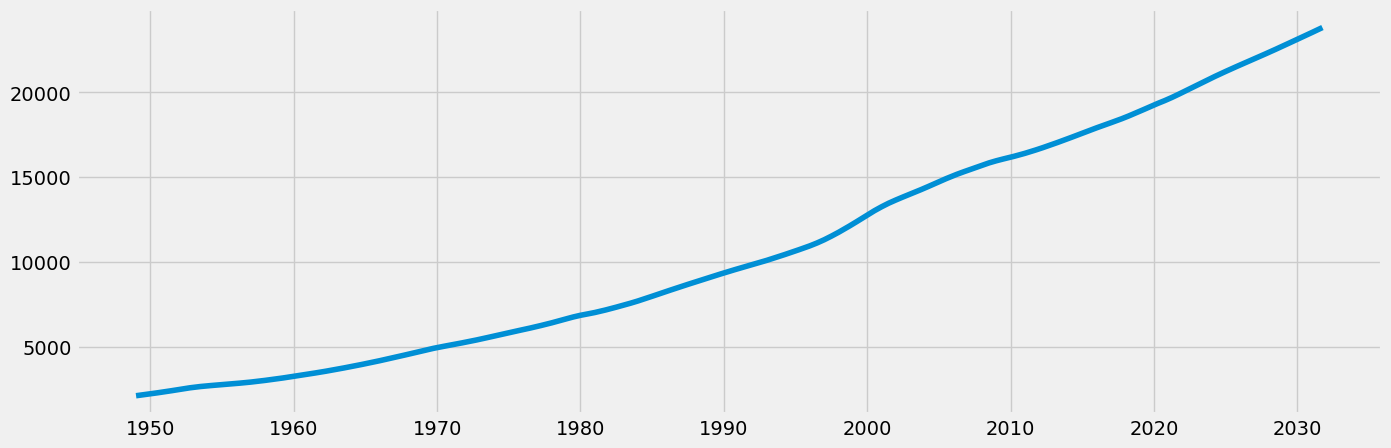

In [12]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [13]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [14]:
data_2.head()

,Date,Value
0,1949-01-01,2102.982630
1,1949-04-01,2130.581305
2,1949-07-01,2159.340530
3,1949-10-01,2186.844859
4,1950-01-01,2216.058359


In [15]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [16]:
data_sub.shape

(162, 2)

In [17]:
data_sub.head()

,Date,Value
124,1980-01-01,6847.481683
125,1980-04-01,6890.146039
126,1980-07-01,6928.061362
127,1980-10-01,6968.010712
128,1981-01-01,7012.104757


In [18]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,6847.481683
1980-04-01,6890.146039
1980-07-01,6928.061362
1980-10-01,6968.010712
1981-01-01,7012.104757


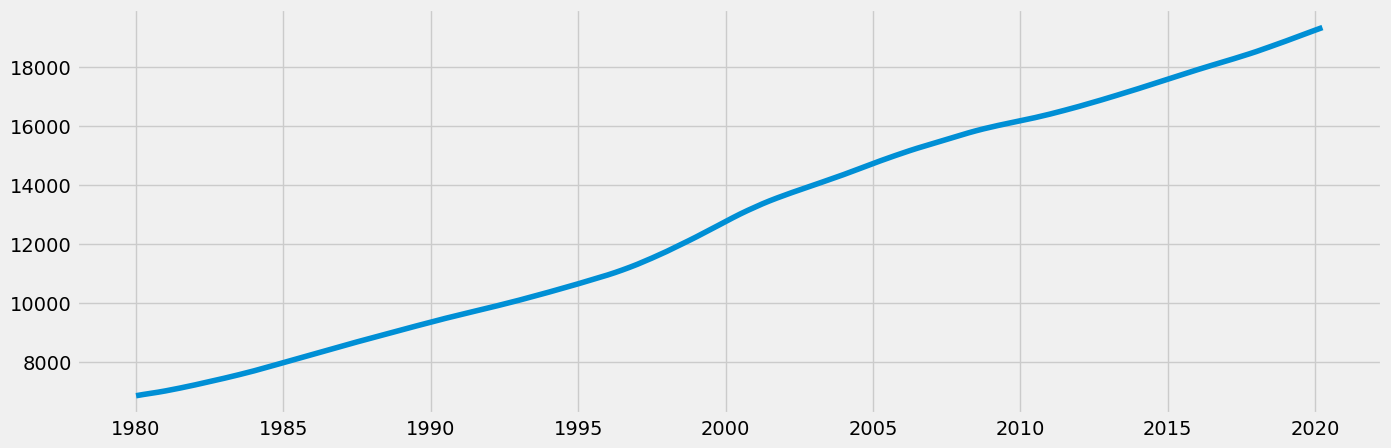

In [19]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [20]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum()

Value    0
dtype: int64

In [21]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [22]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [23]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

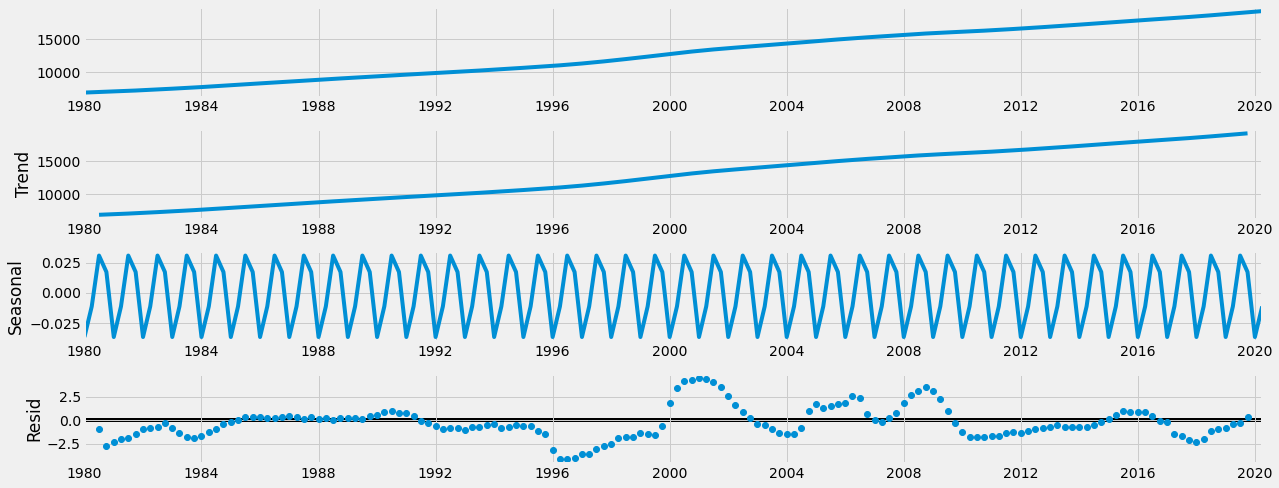

In [24]:
# Plot the separate components

decomposition.plot()
plt.show()

##### The first chart in the figure above is the data itself (including all of its components). This is called the level.
##### The second is the underlying trend.But because you’re working with data that doesn’t have much noise (and, thus, didn’t need to be smoothed), the level and trend appear the same.

##### The third component is the seasonality. Here, you see seasonal fluctuations represented by a spikey curve that changes at a regular interval.
##### And finally comes the noise—or, as it’s called here, “residual.” From 1980 to 2020 there is a noice in the data.
##### The presence of a trend and seasonality implies the series is non-stationary

### 4. Testing for stationarity

In [25]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.137050
p-value                          0.945621
Number of Lags Used              5.000000
Number of Observations Used    156.000000
Critical Value (1%)             -3.472979
Critical Value (5%)             -2.880252
Critical Value (10%)            -2.576747
dtype: float64


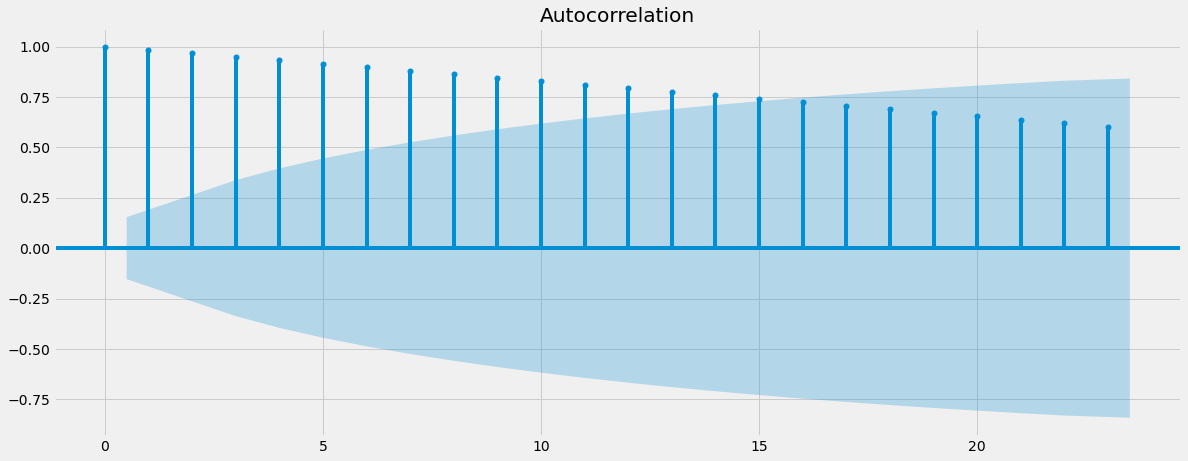

In [26]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

##### Below this is the p-value, which indicates whether the test result is significant. A “significant” result would be a p-value of less than 0.05. Here the P-value = 0.9456 which is greater than 0.05. Hence it is a non-significant result.

##### Test statistic larger than critical value = can’t reject null hypothesis; Here the Test Statistics(-0.137050) is greater than the critical value (5%= -2.880252  & 10% = -2.576747) Menas we cannot Reject the Null Hypothesis.

##### That there is a unit root in your data, and the data is non-stationary. 
##### Real Potential Gross Domestic Product has quite a few lags correlated with each other. This means there’s a lot of autocorrelated data and the set is likely non-stationary, which supports the result of the Dickey-Fuller test you conducted earlier.


In [27]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [28]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [29]:
data_diff.head()

,Value
datetime,
1980-04-01,42.664356
1980-07-01,37.915323
1980-10-01,39.949350
1981-01-01,44.094045
1981-04-01,47.180044


In [30]:
data_diff.columns

Index(['Value'], dtype='object')

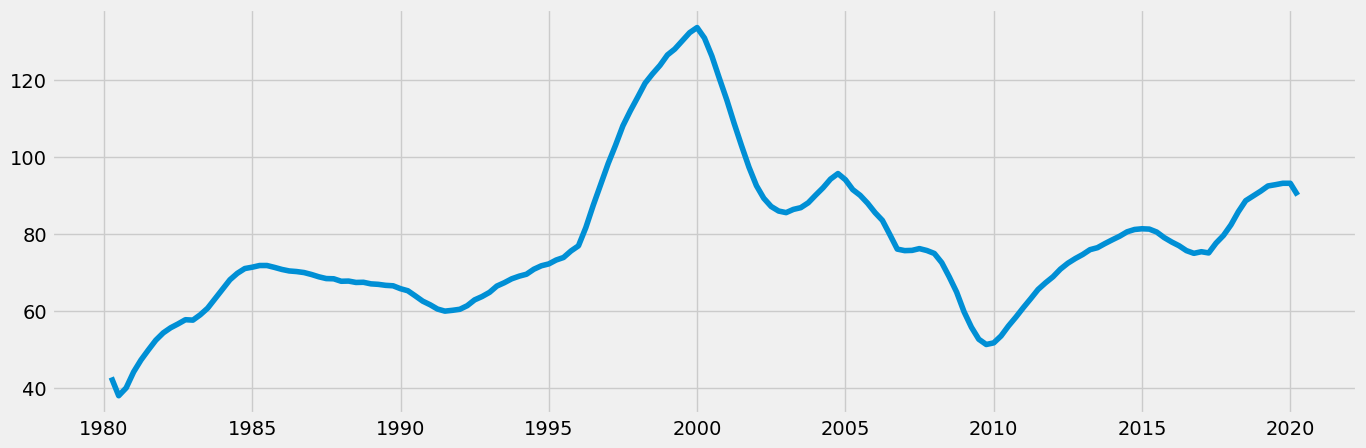

In [31]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [32]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.242815
p-value                          0.191075
Number of Lags Used              4.000000
Number of Observations Used    156.000000
Critical Value (1%)             -3.472979
Critical Value (5%)             -2.880252
Critical Value (10%)            -2.576747
dtype: float64


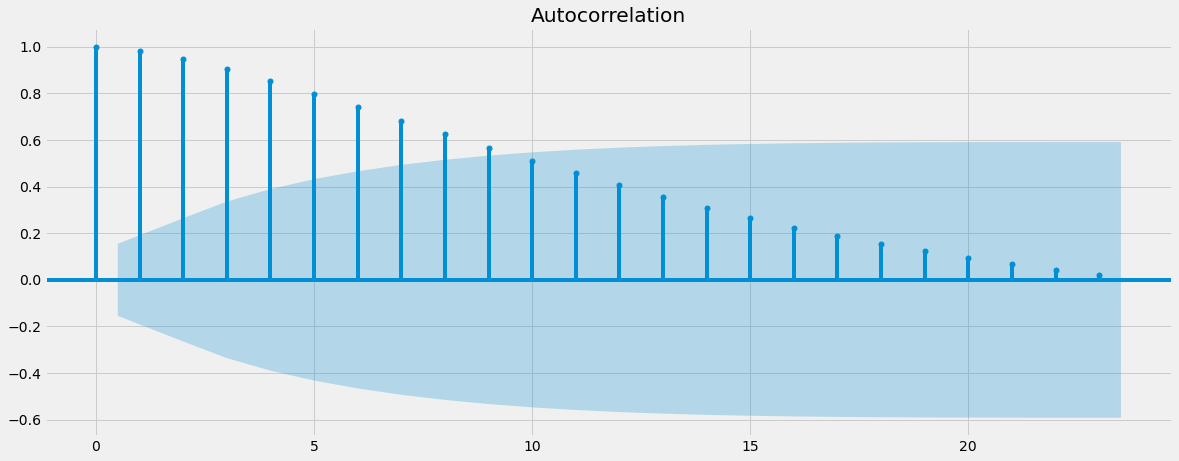

In [33]:
plot_acf(data_diff)
plt.show()

##### Test statistic larger than critical value = can’t reject null hypothesis; Here the Test Statistics(-2.242815) is greater than the critical value (5%= -2.880252  & 10% = -2.576747) Menas we cannot Reject the Null Hypothesis.

##### That there is a unit root in your data, and the data is non-stationary. 
#####  This means need to repeat the deffencing step once again.

### 5.1. Stationarizing the Real Potential Gross Domestic Product 

In [46]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [47]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [48]:
data_diff.head()

,Value
datetime,
1980-04-01,42.664356
1980-07-01,37.915323
1980-10-01,39.949350
1981-01-01,44.094045
1981-04-01,47.180044


In [49]:
data_diff.columns

Index(['Value'], dtype='object')

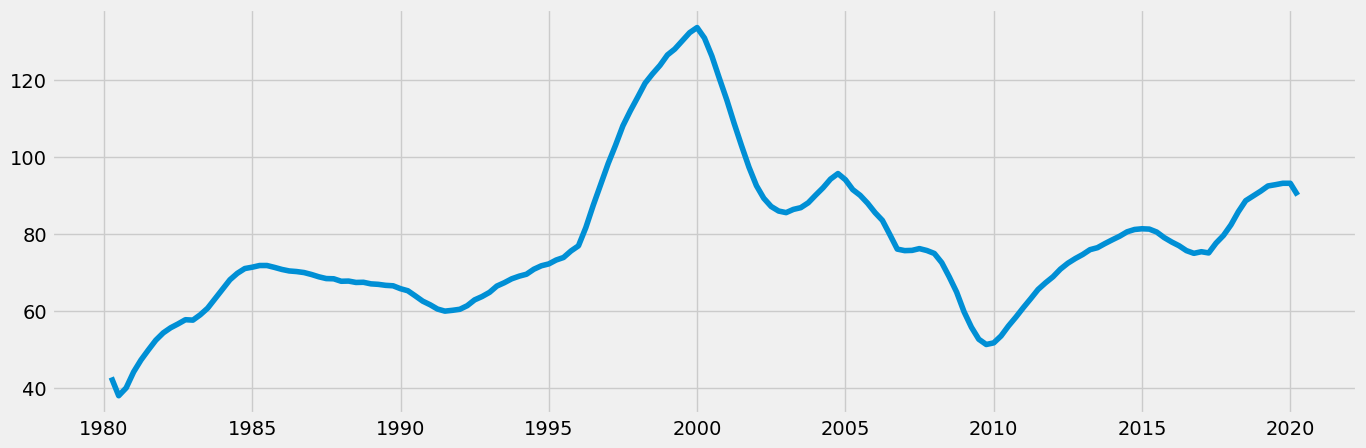

In [50]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [51]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.242815
p-value                          0.191075
Number of Lags Used              4.000000
Number of Observations Used    156.000000
Critical Value (1%)             -3.472979
Critical Value (5%)             -2.880252
Critical Value (10%)            -2.576747
dtype: float64


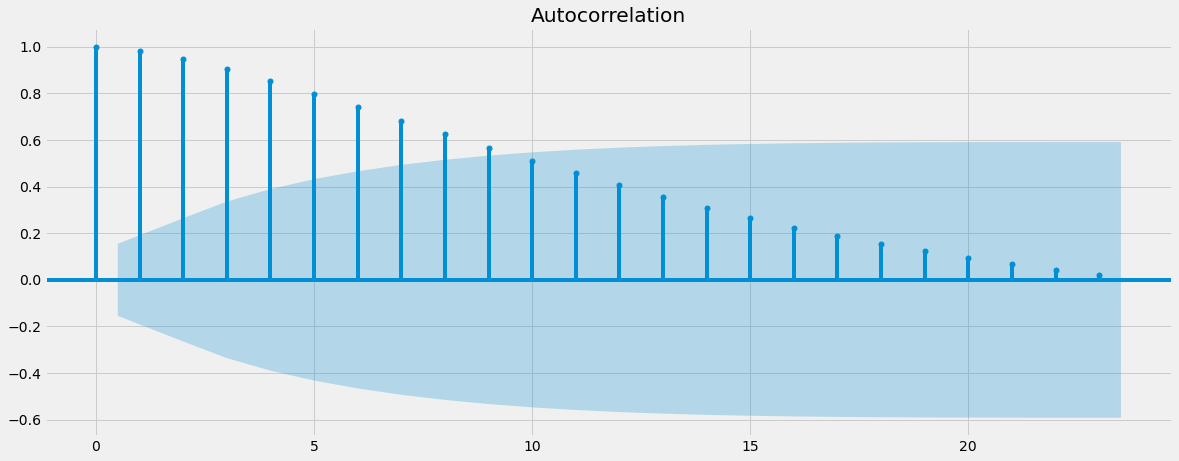

In [52]:
plot_acf(data_diff)
plt.show()

##### Below this is the p-value, which indicates whether the test result is significant. A “significant” result would be a p-value of less than 0.05. Here the P-value = 0.19104which is greater than 0.05. Hence it is a non-significant result.

##### Test statistic larger than critical value = can’t reject null hypothesis; Here the Test Statistics(-2.242815) is greater than the critical value (5%= -2.880252  & 10% = -2.576747) Menas we cannot Reject the Null Hypothesis.

##### That there is a unit root in your data, and the data is non-stationary. 
#####  This means need to repeat the deffencing step once again.